In [30]:
# uncomment below and run once
! pip install nltk scikit-learn

In [ ]:
# notebook by prof. Rebecca Fiebrink
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction import _stop_words
from sklearn.metrics.pairwise import cosine_similarity as cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tokenize.casual import casual_tokenize
import pandas as pd
#from nlpia.data.loaders import get_data
from sklearn.decomposition import TruncatedSVD
import numpy as np
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Session 12 Classification 

### Pandas Data Frames 

Hopefully by now we have a good handle on the data structures for holding data in Python. We've seen **vectors** (1D arrays) and **matrices** (2D arrays, or arrays of arrays). These can either be a native Python `list`, or and `numpy array`. 

We've also seen data frames from the pandas library a few times already, and we've mainly been using them for their nice display qualities, we'll just formally introduce them now as they will start making ever more appearances! 

You can initialise them from an existing array, and use column and row names to index them instead of just numbers!

In [31]:
a = np.array([1,2,3,4])

In [32]:
# Initialising 
# Pass an array or list into the constructor 
a = np.arange(9).reshape((3,3))
df = pd.DataFrame(a)
df = pd.DataFrame(a, columns = ["col1","col2","another boring name"])
df = pd.DataFrame(a, index = ["row1","row2", "row3 your boat"], columns = ["col1","col2","another boring name"])
print(df)

                col1  col2  another boring name
row1               0     1                    2
row2               3     4                    5
row3 your boat     6     7                    8


In [33]:
#Accessing by name or number
print(df["col1"]["row1"])
print(df["col1"][0])

#iloc for indexes
print(df.iloc[0])
print(df.iloc[1])
print(df.iloc[1, 1])

0
0
col1                   0
col2                   1
another boring name    2
Name: row1, dtype: int64
col1                   3
col2                   4
another boring name    5
Name: row2, dtype: int64
4


C:\Users\Marysia\AppData\Local\Temp\ipykernel_36580\2024248313.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df["col1"][0])


### The NewsGroup Dataset

This dataset contains newsgroup posts about space and about hockey.

In [34]:
df = pd.read_csv("../data/space_hockey.csv")

In [35]:
df.

text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [36]:
#See some random space posts
test = df["label"] == 0
random_post = df[test].sample(1)
print(random_post["text"].item())

From: gary@ke4zv.uucp (Gary Coffman)
Subject: Re: Philosophy Quest. How Boldly?
Reply-To: gary@ke4zv.UUCP (Gary Coffman)
Organization: Destructive Testing Systems
Lines: 104

In article <1sti5kINNoq4@gap.caltech.edu> palmer@cco.caltech.edu (David M. Palmer) writes:
>gary@ke4zv.uucp (Gary Coffman) writes:
>>Lack of a skeleton means that muscles have to actively resist
>>gravity at all times on land rather than supplying only balancing
>>forces. That means that much more energy would be required for the
>>creature to function. The bones also supply leverage points for
>>pushing and lateral movement. That's why you don't find large 
>>active boneless creatures on land.
>
>Hydraulics can make rigid tubes.  No energy required just for
>support.  Hydraulics also allow a creature to produce large
>forces with weak muscles, using the principle of a hydraulic jack
>rather than a lever.

This is one of those "yes, but" things. It's true that a hydraulically
pressurized tube can be somewhat more 

In [37]:
#See some random hockey posts
test = df["label"] == 1
random_post = df[test].sample(1)
print(random_post["text"].item())

From: vergolin@euler.lbs.msu.edu (David Vergolini)
Subject: Montreal versue Quebec
Organization: Michigan State University
Lines: 18
NNTP-Posting-Host: euler.lbs.msu.edu
Summary: Montreal wins game 3, but not without controversy.
Keywords: Montreal wins a game to get back into the series

  Did anyone see the Montreal - Quebec game yesterday?  It was tight right down
to the last second of the third period.  In the overtime Roy and Hextall played
like they were gods.
  Ok, so Montreal won!  They deserved it after getting their first goal in
overtime waved off because the puck was hit in with a high stick.  Their second
goal in overtime was also replayed, but I could not tell if it was the Montreal
player who kicked it in.  The puck definitely was not directed in by a stick.
Anyways, Montreal is back into the series.







                                                Dave Vergolini
                                                Michigan State University
                             

In [38]:
#I've added in my own tokens I want to remove
remove = list(_stop_words.ENGLISH_STOP_WORDS) + ["%","!",",",":","@","£","$","&","*","(",")","?","<",">",".","+","_","|","/","-"]
def my_tokeniser(doc):
    #
    tokens =  casual_tokenize(doc)
    processed = []
    for t in tokens:
        #make lowercase
        t = t.lower()
        #Remove stop words
        if not t in remove:
            processed.append(t)
    #Return an array of tokens for that document
    return processed
# Make TFIDF Vectoriser

# more on TF-IDF: https://en.wikipedia.org/wiki/Tf%E2%80%93idf
vectoriser = TfidfVectorizer(tokenizer=my_tokeniser)
# Fit the model
tfidf_model = vectoriser.fit(df["text"])
#Get the vocab
vocab = np.array(tfidf_model.get_feature_names_out())

#Get vectors for everything
vectorised = tfidf_model.transform(df["text"]) #.todense()
vectorised_df = pd.DataFrame(vectorised.todense(), columns = vocab)
#Get vectors for space articles
vectorised_space = tfidf_model.transform(df[df["label"] == 0]["text"])
vectorised_space_df = pd.DataFrame(vectorised_space.todense(), columns = vocab)
#Get vectors for hockey articles
vectorised_hockey = tfidf_model.transform(df[df["label"] == 1]["text"])
vectorised_hockey_df = pd.DataFrame(vectorised_hockey.todense(), columns = vocab)


C:\coding_projects\ual_cci\peckham-daz\24-intro-to-data-science\daz-venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [39]:
#Get SVD vectors
svd = TruncatedSVD(n_components = 16, n_iter = 100) 
svd_topic_vectors = svd.fit_transform(vectorised)

In [40]:
topic_weights = pd.DataFrame(svd.components_.T, index=vocab, columns=['topic{}'.format(i) for i in range(16)])
topic_weights #display it

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15
,0.000422,-0.000241,0.000352,0.000398,0.000634,-0.000024,-0.000084,0.000109,0.000198,-0.000178,0.001843,-0.000037,-0.000972,0.000121,0.000459,0.001395
"""",0.357000,-0.218056,0.099396,-0.109315,0.000278,-0.354352,0.184803,-0.275363,0.191470,-0.011028,-0.269870,0.039086,0.237521,-0.134491,0.191819,0.047395
#,0.035371,0.045059,0.004864,0.007289,-0.016405,-0.005365,-0.021648,0.003690,0.039505,0.002727,-0.007519,-0.020254,0.021837,0.059578,-0.032228,-0.046982
###___,0.000617,0.000110,-0.000808,0.000483,-0.001313,-0.000712,-0.001182,-0.001182,0.000285,-0.000189,0.000019,-0.000362,0.000408,0.000921,0.002288,-0.000389
#0362,0.001209,-0.001355,0.001906,-0.001022,0.000004,-0.000420,0.000647,0.001524,-0.001376,0.001045,-0.000234,-0.001567,-0.001839,-0.000858,0.000290,-0.000094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
{=,0.000476,-0.000264,0.000597,0.000019,-0.000629,0.001485,0.000087,-0.001709,0.000845,0.000809,-0.000127,0.000106,0.000005,0.001021,0.000800,-0.000346
|-=,0.000534,0.000653,0.001153,0.007039,0.006593,-0.000108,-0.001983,-0.000672,0.001475,-0.000926,-0.002422,-0.000446,0.000640,-0.000104,0.000974,-0.002635
},0.005507,0.001713,0.005345,0.002423,-0.000254,-0.001714,-0.001009,0.002067,-0.005284,0.000578,0.000904,0.007490,-0.001999,0.005598,-0.009240,-0.009018
};,0.000068,-0.000036,0.000188,0.000141,0.000046,-0.000013,0.000003,0.000159,-0.000076,0.000015,0.000026,0.000101,0.000153,0.000042,-0.000101,-0.000247


In [41]:
topic_weights.topic2.sort_values(ascending=False).head(10) # show top 10 weighted words for topic 2

0          0.266929
space      0.241685
1          0.226604
=          0.143722
henry      0.111980
shuttle    0.109871
"          0.099396
2          0.092341
hst        0.091610
mission    0.088765
Name: topic2, dtype: float64

# Supervised Machine Learning 

But what if we had specific labels that we wanted to attach to documents that we knew about before hand? 

- Is this text spam or not?
- Is this book about horror, sci-fi or cooking?
- Is this song going to be a hit?

This is where **supervised machine learning** comes in, specifically, **classification**. 

To try and get a feel for the task of classification, we're going to have a look at each class and see if we think it wll be easy to a computer program that can pick apart these two groups.

We're going to try an experiment to see if we can find two words that would allow us to decide if a document was from the space group or the hockey group.

In [42]:
#Sum up TFIDF score for each word across all documents
space_sums = pd.DataFrame(vectorised_space.sum(axis = 0).T, index=vocab, columns = ["sums"])
hockey_sums = pd.DataFrame(vectorised_hockey.sum(axis = 0).T, index=vocab, columns = ["sums"])
print("\nSPACE:\n", space_sums["sums"].sort_values(ascending=False).head(30), "\nHOCKEY:\n", hockey_sums["sums"].sort_values(ascending=False).head(30))


SPACE:
 "                    56.400999
space                41.481367
'                    19.142211
writes               18.996641
=                    17.619078
subject              16.957876
article              16.869986
moon                 16.705737
lines                16.551744
...                  16.489472
henry                16.449825
organization         16.370213
shuttle              16.215700
pat                  16.187846
like                 15.905841
just                 15.472184
nasa                 15.444643
..                   15.033720
orbit                14.740173
launch               13.623463
nntp-posting-host    13.179468
don't                12.937445
sky                  12.795349
mission              12.665510
hst                  12.335688
spencer              11.741638
___                  11.504386
earth                11.503030
u                    11.436734
distribution         10.935915
Name: sums, dtype: float64 
HOCKEY:
 "                    37.

### Selecting the TFxIDF values for a specific token

We're going to plot the `TFxIDF` values for **each post** for **two specific tokens**.

The arrays that hold our `TFxIDF` values have the shape ``numPost x lengthOfVocab`` 

In [43]:
vectorised.shape

(1977, 34959)

We can use a **filter** to get the indexer of a **given token**

``
filter = vocab == features[0]
``

Then we can grab all the rows (using the `colon :`), given that column. 

We end up with **2 features** for each token, which we can plot on a graph. The colour represents **which news group the post was originally from**.

### Indexes **and** objects in `for loops` with `enumerate()`

Previously, we have looked at two main approaches to `for loops`. We either iterate through an array and get the **values themselves**

```
chapters = ["chapter1", "chapter2", "chapter3"]
for c in chapters:
    analyse(c)

```

Or we've used `range()` to iterate over some indexes

```
chapters = ["chapter1", "chapter2", "chapter3"]
for i in range(len(chapters)):
    analyse_chapter_at(i)

```

But **YOU CAN HAVE THEM BOTH**

Below, we use the `enumerate()` function. This returns **two values** stored in **two separate variables**. The first contains the index, and the second the actual object. 

Turns out you can have it all. 

Check out the code below and see if you can understand it!

In [44]:
?ax.plot

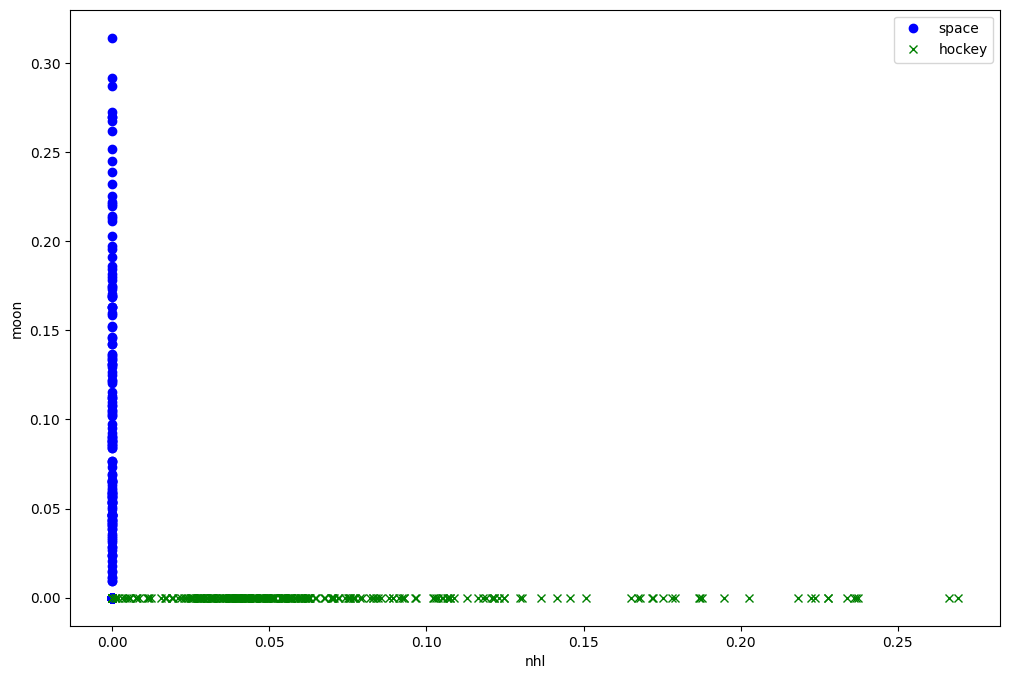

In [45]:
#Which TFIDF scores would be useful when trying to determine which class?
import matplotlib.pyplot as plt
classes = [vectorised_space.todense(), vectorised_hockey.todense()]

#Good features
features = ['nhl', 'moon']

#Bad features
#features = ['article', 'subject']

fig, ax = plt.subplots(figsize=(12,8))
col = "bo"
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
for i, c in enumerate(classes):
    #Get TFIDF for all posts, for the column for each vocab
    x = c[:, vocab == features[0]]
    y = c[:, vocab == features[1]]
    ax.plot(x, y, col, label = "space" if i == 0 else "hockey")
    col = "gx"
ax.legend()

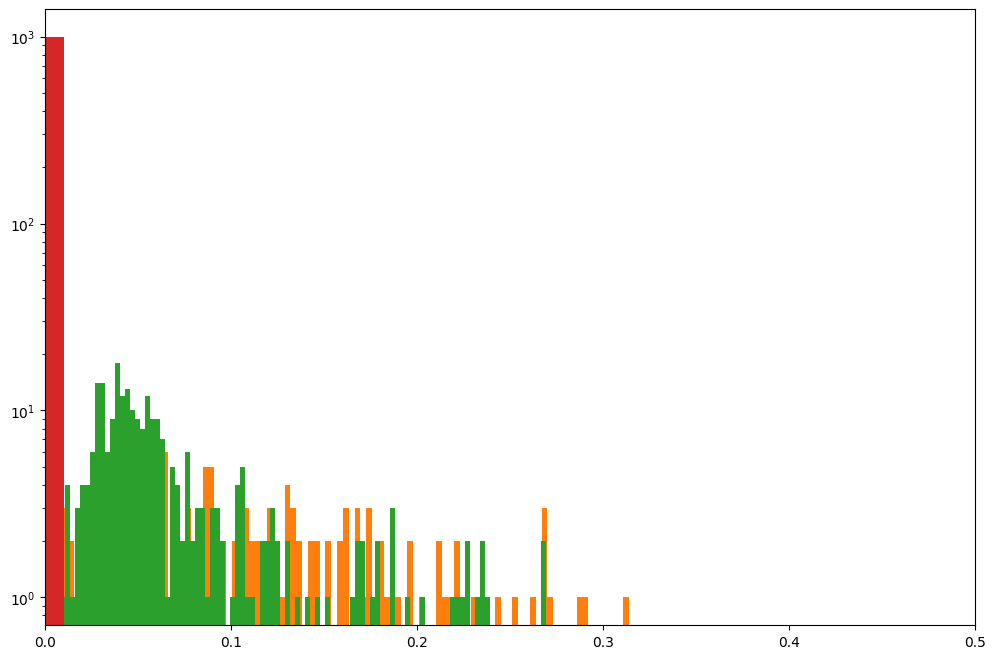

In [46]:
#Lots of values near 0
fig, ax = plt.subplots(figsize=(12,8))
for i,c in enumerate(classes):
    x = c[:, vocab == features[0]]
    y = c[:, vocab == features[1]]
    ax.set_xlim([0,0.5])
    ax.set_yscale("log")
    
    ax.hist(x, bins = 100)
    ax.hist(y, bins = 100)
    

### Supervised Learning Overview

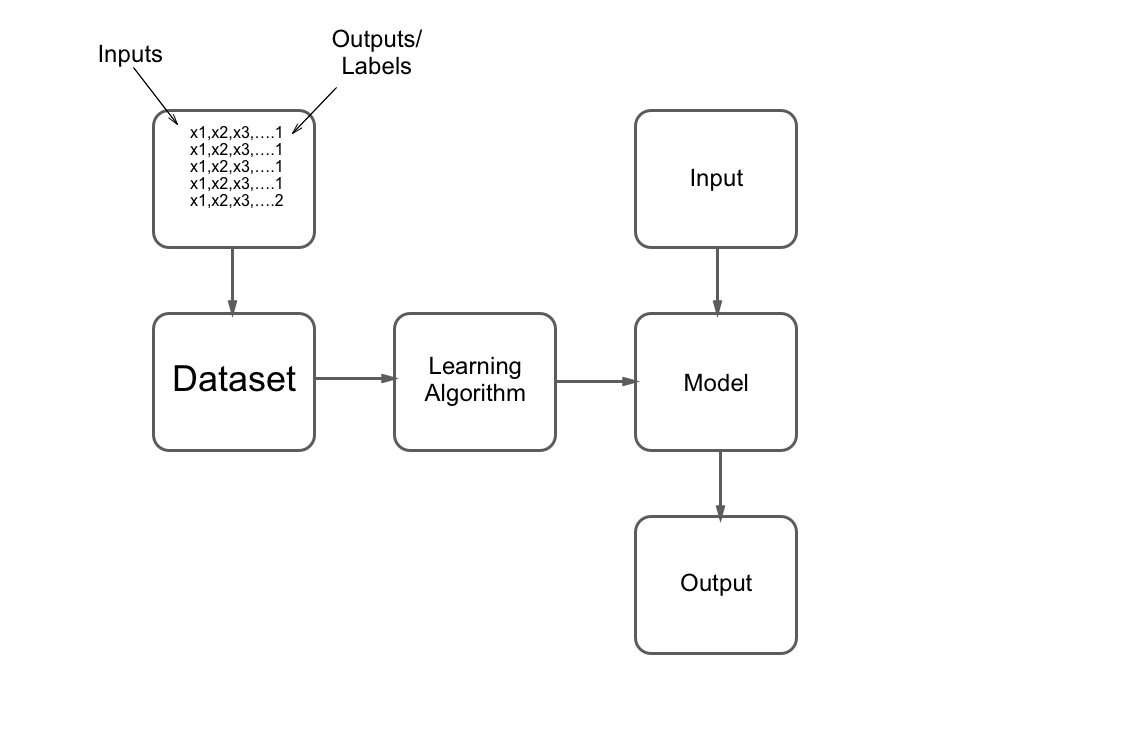

In [47]:
from IPython.display import Image
Image("../media/supervisedlearninglearner.png")

### Models

Models don't have to be constructed with machine learning. The model is simply something that when given an **input**, which in our case waill be some vectorised text, it is able to produce some **output**. In the case of **classification** this will always be a single discrete label. 

This model could be made by hand, and in fact some text classification models were made by hand until quite recently. However, this can be time consuming and complicated, and result in models which are not particularly robust. 

Machine learning allows us to make **models** from **data**. This means that given **new data** that the model hasn't seen before, we can assign a new label to that new data. 

### Whats the simplest data-driven model?

Lets think of the simplest model we can make, using the data we have. For example, we could get 50% accuracy by just picking the same class every time without even looking at the data. Generally, we would hope to be doing better than **mean** or chance!

We can do much better than that using **learning algorithms** to generate our models in a process called **training**. We will cover a couple of learning algorithms used for classification later in the lecture. 


### Datasets

The format of our dataset is quite simple. Each example (in our case each text document), is represented by 1 or more numbers. This might be a Bag of Words Vector, a TF/IDF vector, or a Topic Model Vector, or some other representations we'll learn about later on in the course. 

This is the **input**. Each example also has a label, or an **output**. This label tells us which class the example belongs to and we can use this to **train** our model.

#### Labels
A quick word on labels in classification tasks. They are:

- Discrete (https://statisticsbyjim.com/basics/discrete-vs-continuous-data/)
- Categorical (not numerical, although we often use numbers). 1 is not less than 2, 3 is not half 6. 



### Training 

This is where we take the dataset (the input that represents each example, and its accompanying label), and generate a model that will learn to take new inputs, and be able to correctly label them. 

The way this happens is often starting from some random initialisation, we iteratively try each example, check if we got it right by comparing the model's prediction against the actual label, and then use this information to improve the model. Eventually, we end up with a model that works well (hopefully!). 

The algorithms we'll look at today actually don't really have much of a training process as such, unlike the more fancy learning algorithms we'll look at later in the course. 

### New Data

Now we've trained the model, its time to try it out on some new data! Remember, the goal is to make something that is able to correctly label new data (new instances of text) based on what it has learned about the categories from the dataset. It is worth noting here that models will only tend to be good at identifying new examples that are similar, or at are least different in similar ways, to the ones it has seen before.  

We'll look into how to evaluate our models later on. 

In [48]:
from sklearn.naive_bayes import GaussianNB

#Pick features
#features = ["subject","article"]

features = ["moon","nhl"]
#features = ["space","hockey", "moon","nhl"]
# features = np.random.choice(vocab, 100)

#Add features to main dataframe

vectorised_dense = vectorised.todense()


for f in features:
    df[f] = vectorised_dense[:, vocab == f]
#Initialise the model
gnb = GaussianNB()

#Get the dataset
X = df[features]
y = df["label"]

print(X.shape, y.shape)

#Train the model
model = gnb.fit(X, y)

#See if the model works
y_pred = model.predict(X)

#How many did it get right?
num_incorrect = (y != y_pred).sum()
total = df["label"].shape[0]
acc = (total - num_incorrect) / total * 100
print("Number of mislabeled points out of a total %d points : %d, %0.3f" % (total, num_incorrect, acc))

(1977, 2) (1977,)
Number of mislabeled points out of a total 1977 points : 832, 57.916


### How good is that score?

Is the model better than random? Here we show what happens if we randomly guess a label.

In [49]:
#Generate some random results
y_pred = np.random.randint(0,2,len(y))

#How many did it get right?
num_incorrect = (y != y_pred).sum()
total = df["label"].shape[0]
acc = (total - num_incorrect) / total * 100
print("Number of mislabeled points out of a total %d points : %d, %0.3f" % (total, num_incorrect, acc))

Number of mislabeled points out of a total 1977 points : 955, 51.694


### Good for some....

For some examples the two words are really good, but for some examples where the TF/IDF for each word is near 0, its a bad representation

For example, out of 1000 of each category, we may have a 300 space emails where the features are (0,0), and 400 hockey emails where the features are (0,0). SO if we then have a new email that scores (0,0), what category do with put it in? We can't use just these features to reliably tell them apart!

In [50]:
#Get the accuracy 
acc = (total - num_incorrect) / total * 100
acc

np.float64(51.694486595852304)

### Evaluating Models 

#### Training Set Accuracy
Training set accuracy is when we take all the data we trained the model on and use it to determine the accuracy of that same trained model. It's important to remember that the goal of most traditional machine learning tasks is to take existing examples and produce something which generalises to new examples. 

In an issue known as overfitting, a model may have high training set accuracy, but when given new examples will perform poorly. In our text blog example, this means the model has learnt to identify the exact blog posts it has seen before, rather than learning something intrinsic about all space or hockey emails that would allow it to correctly label novel ones under different circumstances in the wild. 

#### Validation Set Accuracy
To get a more accurate measure of accuracy (meta, right?), you can hold back some of your data from training and use this to evaluate your model during development. This way your model is being tested on unseen data and you can have more confidence it will work when you put it into production. Proportions for this split vary, but 10% is often used.

The problem with test set accuracy is that you lose some of your precious data for training. Also, if you have small datasets, a 10% split of an already small number of examples may not actually give you much of an idea about how well your model is performing. 

You can see that no one method is right for all situations and compromises often have to be made. It's also important to note that these methods will only work as well as your data is good. They won’t, for example, spot bias in your model if your test set also lacks the necessary diversity. 

#### Test Sets
Some people hold back even more data to really test how well their model will work in the real world (or "production"). This is because they may overfit to their testing data when tuning their models. 

#### Cross Validation 
Its the best (or worst?) of both worlds approach! More on that later.

### `train_test_split(X, y, split)`

There is a function in the `sklearn` library that we can use called `train_test_split()` we can use to create our different datasets for **training** and **validation**.

In [51]:
#Add features to main dataframe
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vectorised_df, df["label"], test_size=0.2, random_state=0)
#Train the model
model = gnb.fit(X_train,y_train)
#See if the model works
y_pred = model.predict(X_test)
num_incorrect = (y_test != y_pred).sum()
total = y_test.shape[0]
acc = (total - num_incorrect) / total * 100
print("Number of mislabeled points out of a total %d points : %d, Accuracy is %0.3f percent" % (total, num_incorrect, acc))

Number of mislabeled points out of a total 396 points : 3, Accuracy is 99.242 percent


In [52]:
##Look up the documentation using ?
?train_test_split

### Comparing Representations

OK, so now we can compare TF/IDF, SVD and LDA representations, remember, one isn't better than the other for all datasets and problems. One might be better for this dataset and problem. 

In [53]:
# Set things up
lda_cv = CountVectorizer(stop_words='english', tokenizer=my_tokeniser,
                        max_df=.1,
                        max_features=5000)
count_data = lda_cv.fit_transform(df["text"])
lda = LatentDirichletAllocation(n_components=16,
                                random_state=123,
                                learning_method='batch')

C:\coding_projects\ual_cci\peckham-daz\24-intro-to-data-science\daz-venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [54]:
# PLEASE note this is unsupervised learning
lda_topics = lda.fit_transform(count_data)

In [55]:
#Compare the 3 representations
tfidf = np.asarray(vectorised.todense())
features = [tfidf, svd_topic_vectors, lda_topics]
i = 0
for f in features:
    print("Feature set ",i)
    i = i+1
    X_train, X_test, y_train, y_test = train_test_split(f, df["label"], test_size=0.3, random_state=0)
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    num_incorrect = (y_test != y_pred).sum()
    total = y_test.shape[0]
    acc = (total - num_incorrect) / total * 100
    print("Number of mislabeled points out of a total %d points : %d, %0.3f accurate" % (total, num_incorrect, acc))

Feature set  0
Number of mislabeled points out of a total 594 points : 5, 99.158 accurate
Feature set  1
Number of mislabeled points out of a total 594 points : 32, 94.613 accurate
Feature set  2
Number of mislabeled points out of a total 594 points : 36, 93.939 accurate


### Naive Bayes

Now we're going to learn about the algorithm that we've been using to classify, as it is one widely used in text classification tasks. 

When we see a new example we ask "Given I know that this document has these feature values, what is the probability that it is from each class?". Naive Bayes will then return the **most likely** label, given those values. 

```
P(c=0|x1,x2,x3..)
P(c=1|x1,x2,x3..)
```

How we reach this probability is in two steps.

First, we ask "What is the probability that a document in a particular class has these particular values?". We can look at a **probability distribution** (as shown in the plot below) to work this out. For example, we may see that that for **space (class 0)**, the probability of a seeing a **TF/IDF** score of 0.4 for the word **year** might be 0.084 and the probability in **hockey (class 1)** is only 0.069. 

```
P(time=0.4|c=0) = 0.084
P(time=0.4|c=1) = 0.069
```

prob =  0.0840703196980875
prob =  0.0690159906776055


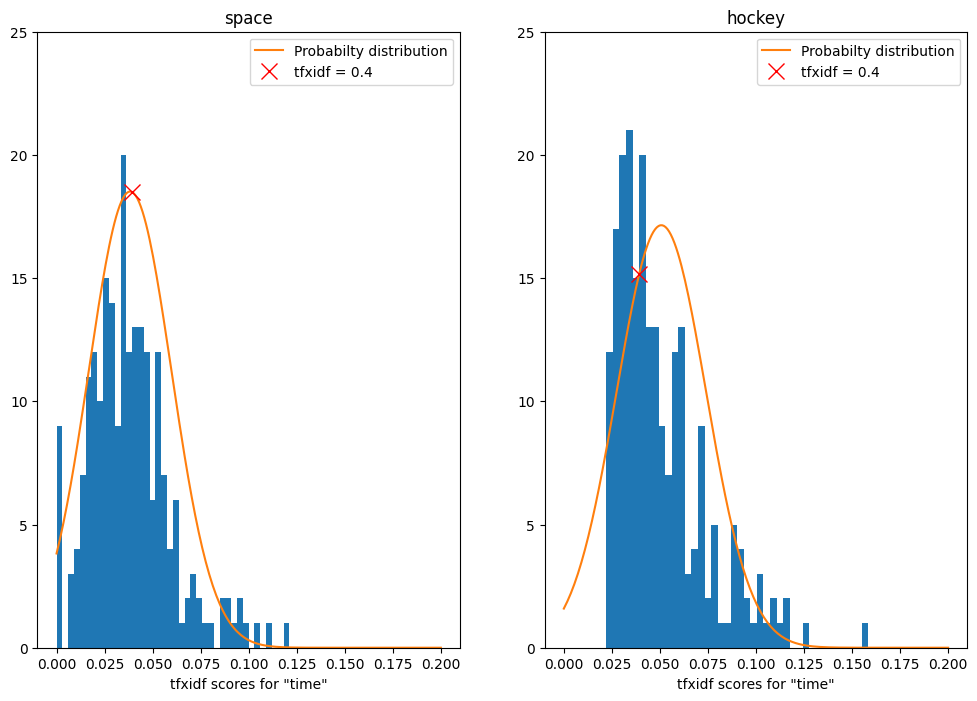

In [56]:
from scipy import stats 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
feature = "time"
for i,c in enumerate(classes):
    #Get vals for word
    tfidf_vals = c[:, vocab == feature]
    lim = 220
    #Remove 0 scores (for plotting)
    tfidf_vals = sorted(np.array(tfidf_vals.flatten())[0])[-lim:]
    x = np.linspace(0, 0.2, len(tfidf_vals))
    #Find mean and standard deviation
    m, s = stats.norm.fit(tfidf_vals)
    #Draw normal curve
    pdf_g = stats.norm.pdf(x, m, s)
    ax[i].set_ylim([0,25])
    ax[i].hist(tfidf_vals, bins = 40)
    ax[i].plot(x, pdf_g, label="Probabilty distribution")
    index = 43
    print("prob = ", pdf_g[index]/len(tfidf_vals))
    ax[i].plot(x[index], pdf_g[index],"rx",ms=12, label="tfxidf = 0.4") 
    ax[i].set_xlabel("tfxidf scores for \"" + feature +"\"")
    ax[i].set_title("space" if i == 0 else "hockey")
    ax[i].legend()


But this is not enough, because it may also be that **regardless** of observations, it's actually way more likely that you'll get one class over another. 

In our case the classes are nicely balanced so this won't have much effect, because the chance of seeing each class, regardless of what we know about the text, is about 50/50

But using **Bayes Rule** we can calculate the probability of each class, given the observation, taking into account the probability before you had made the observation. 

```
P(c=0|year=0.1) = P(c=0) * P(year=0.1|c=0)
P(c=1|year=0.1) = P(c=1) * P(year=0.1|c=1)
```

But this is only for one of the features, and as we've seen, we may use anywhere from 1 to thousands! 

We can calculate each probability for each feature separately and combine them to get a final probability and this is where the **naive** in **naive bayes** comes in. 

The maths that we use to combine the probabilities assumes that all the features are independent and unrelated, however, it is quite likely that some will actually be related in some way. We ignore this assumption and use it anyway and it turns out it sitll works quite well!

## Summary

### Classification only works for what you trained it for 

1. Will always make pick one of the classes it's been trained on 


2. Data has to be in the same format 


### Uses of Text Classification in Creative Industries 

- Classifying social media response to events 


    - Did people enjoy the show?


- Grouping media from text descriptions 


    - Can help if we have categories that we know are useful


- Identifying new items in museum collections 


    - Which experts should look at these documents?


- Filtering out inappropriate content 


    - Live performances with audience participation 

### Rules of Thumb

 - A model is created by a learning algorithm 
 
 
 - A classifier learns to attach labels to new data in the form of discrete numbers (https://statisticsbyjim.com/basics/discrete-vs-continuous-data/)
 
 
 - We want a model that works well with new data (generalises well, **not overfit**)
 
 
 - Different features can affect model performance
 
 
 - The model can only learn variations similar to that it has seen before  
     
     
     - Generally less features is better
     
     
     - Generally more data is better, especially for more complex problems 
     
     
 - More classes (more choices), generally is a harder problem 
 
 
 - Equal numbers of examples for each class is also generally better